# criticism_detection.ipynb

### 1 ###
•	It analysis papers citing another one that has been retracted.
•	It takes papers that triggered the retraction and classify them as highly_critical.
•	Papers published a year before the first highly_critical paper are classified as non_critical.
•	Papers published after the highly_critical papers are classified as critical (they are not used in the analysis later on because they may contain mixed criticism).
•	Date of publication of the papers are taken from the “PMC-ids.csv.gz” file, available through the PMC FTP service:
https://www.ncbi.nlm.nih.gov/pmc/pmctopmid/

### 2 ###
•	It takes all the sentences citing a particular DOI in all the papers disregarding its section. 
•	It shows that clustering algorithms such as PCA and TSNE fail if trying to cluster the sentences from non_critical and high_critical papers just using vader lexicon.

### 3 ###
•	It gets all the sentences in the high_critical papers and a similar number of sentences from the non_critical papers. I finds the words and bigrams used in the high_critical set and are not used in the non_critical set.


### 1 ###

•	It analysis papers citing another one that has been retracted.
•	It takes papers that triggered the retraction and classify them as highly_critical.
•	Papers published a year before the first highly_critical paper are classified as non_critical.
•	Papers published after the highly_critical papers are classified as critical (they are not used in the analysis later on because they may contain mixed criticism).
•	Date of publication of the papers are taken from the “PMC-ids.csv.gz” file, available through the PMC FTP service:
https://www.ncbi.nlm.nih.gov/pmc/pmctopmid/

In [1]:
import re
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "/project/elife/modules")
import words_frec_analysis_get_sentence

file_df = '/project/elife/data/analysis/df_science1179052_retracted.csv'

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])

#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']


In [2]:
import pandas as pd

file_df_ids = '/project/PMC_ids/PMC_ids.csv'
df_ids = pd.read_csv(file_df_ids, sep=',', encoding='utf-8')


df_ids_select = df_ids[df_ids['DOI'].isin(df.citing_DOI)]
"""
for element in df.citing_DOI:
    df_ids['DOI'].isin(df.citingDOI)
    df_ids_selection2.append(df_ids[[df_ids["DOI"] == element]])
    #print(element)
"""

#df_ids_selection
    

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'\nfor element in df.citing_DOI:\n    df_ids[\'DOI\'].isin(df.citingDOI)\n    df_ids_selection2.append(df_ids[[df_ids["DOI"] == element]])\n    #print(element)\n'

In [3]:
# The paper was retracted based on:
DOI_high_critical = ['10.1186/1742-4690-7-63', '10.1371/journal.pone.0008519', '10.1136/bmj.c1018', '10.1186/1742-4690-7-10', '10.1371/journal.pone.0008519', '10.1186/1743-422X-7-224']

df_ids_select_info_highCritical = df_ids[df_ids["DOI"].isin(DOI_high_critical)]

df_ids_select_nonCritical = df_ids[((df_ids["Year"] < 2011)) & (df_ids['DOI'].isin(DOI_high_critical) == False)]

df_ids_select_Critical = df_ids[(df_ids["Year"] >= 2011) | (df_ids['DOI'].isin(DOI_high_critical))]


df_highCritical =df[df['citing_DOI'].isin(df_ids_select_info_highCritical['DOI'])]
 
df_nonCritical = df[df['citing_DOI'].isin(df_ids_select_nonCritical['DOI'])]
df_Critical = df[df['citing_DOI'].isin(df_ids_select_Critical['DOI'])]
#df_critical

df_highCritical_text_part1 = df_highCritical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_highCritical_text_part2 = df_highCritical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_highCritical_text_part3 = df_highCritical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_highCritical = pd.concat([df_highCritical_text_part1, df_highCritical_text_part2, df_highCritical_text_part3]).dropna().reset_index(drop=True)
df_full_highCritical['label'] = 'high_critical'

df_part1 = df_nonCritical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_part2 = df_nonCritical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_part3 = df_nonCritical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_nonCritical = pd.concat([df_part1, df_part2, df_part3]).dropna().reset_index(drop=True)
df_full_nonCritical['label'] = 'non_critizising'

df_part1 = df_Critical[['citing_DOI','sentence_citing_conclusions']].rename(columns = {'sentence_citing_conclusions': 'text'})
df_part2 = df_Critical[['citing_DOI','sentence_citing_discussion']].rename(columns = {'sentence_citing_discussion': 'text'})
df_part3 = df_Critical[['citing_DOI','sentence_citing_intro']].rename(columns = {'sentence_citing_intro': 'text'})
df_full_Critical = pd.concat([df_part1, df_part2, df_part3]).dropna().reset_index(drop=True)
df_full_Critical['label'] = 'critizising'

df_full = pd.concat([df_full_nonCritical, df_full_Critical]).reset_index(drop=True)

                       

In [4]:
print("df_highCritical.shape; ", df_highCritical.shape)
print("df_Critical.shape; ", df_Critical.shape)
print("df_nonCritical.shape: ", df_nonCritical.shape)
print("df_full.shape: ", df_full.shape)

df_highCritical.shape;  (3, 15)
df_Critical.shape;  (21, 15)
df_nonCritical.shape:  (19, 15)
df_full.shape:  (38, 3)


In [5]:
df_highCritical

,cited_DOI,cited_in_conclusions,cited_in_discussion,cited_in_introduction,cited_in_maintext,citing_DOI,conclusions_found,discussion_found,introduction_found,maintext_found,reference_id,sentence_citing_conclusions,sentence_citing_discussion,sentence_citing_intro,sentence_citing_maintext
18,10.1126/science.1179052,False,True,True,True,10.1186/1742-4690-7-10,True,True,True,True,B8,NaN,"['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] co...","['More recently, additional groups of samples ...","['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] (T..."
19,10.1126/science.1179052,False,False,False,True,10.1186/1742-4690-7-63,False,False,False,True,B15,NaN,NaN,NaN,"['More recently, XMRV has also been found, wit..."
38,10.1126/science.1179052,False,True,True,True,10.1186/1743-422X-7-224,True,True,True,True,B3,NaN,['The virus was not detected in any of our stu...,"['In a recent US study, Lombardi et al [<xref ...",['This sequence was obtained by overlapping ex...


### 2 ###

•	It takes all the sentences citing a particular DOI in all the papers disregarding its section. 
•	It shows that clustering algorithms such as PCA and TSNE fail if trying to cluster the sentences from non_critical and high_critical papers just using vader lexicon.

Let's try to use vader_lexicon and pca and tsne to cluster papers criticising and not criticising. 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

# Get Vader data for sentiment analysis
import nltk
nltk.download('vader_lexicon') 

# dictionary of colours for making nice plots later
COLOURS = {'< 2011': '#E91D0E', '> 2011': '#00A6EF'}

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


(<matplotlib.figure.Figure at 0x7f01ae174b00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01ae176748>)

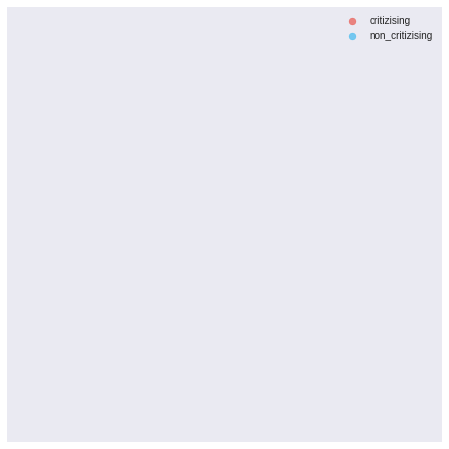

In [7]:
# dimension reduction algorithms can be pretty slow, so let's work with a sample
# try on the whole data set if you want!
from sklearn.decomposition import PCA
import seaborn as sns

def scatter(x, colors):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    ax.scatter(x[(colors==0),0], x[(colors==0),1], c=COLOURS['< 2011'], label='critizising', alpha=0.5)
    ax.scatter(x[(colors==1),0], x[(colors==1),1], c=COLOURS['> 2011'], label='non_critizising', alpha=0.5)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    plt.legend()
    
    return f, ax

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_vectors = tfidf_vectorizer.fit_transform(df_full['text'])

pca = PCA(n_components=2)
pca_comp = pca.fit_transform(tfidf_vectors.toarray())
scatter(pca_comp,df_full['label'])

(<matplotlib.figure.Figure at 0x7f01af0bc5c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f01aa085c88>)

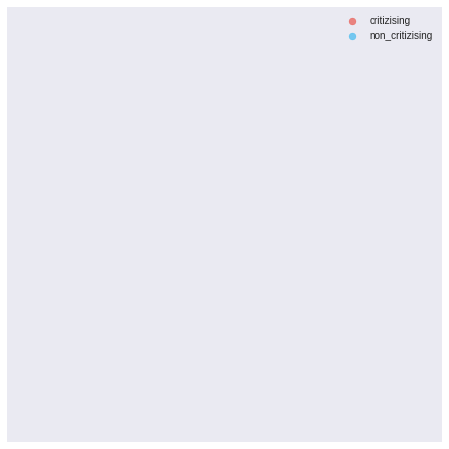

In [8]:
from sklearn.manifold import TSNE

# we have suggested some parameters below, feel free to experiment
tsne = TSNE(perplexity = 800, random_state = 42)

tsne_comp = tsne.fit_transform(tfidf_vectors.toarray())

scatter(tsne_comp,df_full['label'])

As expected it fails PCA and TSNE using vader lexicon fails.

### 3 ###
•	It gets all the sentences in the high_critical papers and a similar number of sentences from the non_critical papers. I finds the words and bigrams used in the high_critical set and are not used in the non_critical set.


Let's analyse the sentences where the paper is cited.

In [20]:
import re
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "/project/elife/modules")
import words_frec_analysis_get_sentence
import imp
imp.reload(words_frec_analysis_get_sentence)


#print("df_highCritical.shape; ", df_highCritical.shape)
#print("df_Critical.shape; ", df_Critical.shape)
#print("df_nonCritical.shape: ", df_nonCritical.shape)
#print("df_full.shape: ", df_full.shape)

#file_df = '/project/elife/data/analysis/df_science1179052_retracted.csv'

#file_df = '/project/elife/data/analysis/df_1000_1000v2_prep_.csv'
#df = pd.read_csv(file_df, sep='\t', header = None, encoding='utf-8', names = ['cited_DOI','cited_in_conclusions','cited_in_discussion','cited_in_introduction', 'cited_in_maintext', 'citing_DOI','conclusions_found', 'discussion_found', 'introduction_found','maintext_found', 'reference_id', 'sentence_citing_conclusions','sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext'])
#  df['cited_DOI', 'cited_in_conclusions','cited_in_discussion',
#    'cited_in_introduction', 'cited_in_maintext', 'citing_DOI',
#    'conclusions_found', 'discussion_found', 'introduction_found',
#    'maintext_found', 'reference_id', 'sentence_citing_conclusions',
#    'sentence_citing_discussion', 'sentence_citing_intro', 'sentence_citing_maintext']

df_full_highCritical_sample = df_full_highCritical # All the papers the retraction is based on
#df_full_highCritical_sample = df_full_Critical.sample(4, random_state = 1)

sentences_highCritical = df_full_highCritical_sample.text.dropna()
frequent_words_highCritical = words_frec_analysis_get_sentence.analysis_nolimit(sentences_highCritical)

# I get a similar number of nonCritical text paragraphs:
df_full_nonCritical_sample = df_full_nonCritical.sample(2*sentences_highCritical.shape[0], random_state = 10)

sentences_nonCritical = df_full_nonCritical_sample.text.dropna()
frequent_words_nonCritical = words_frec_analysis_get_sentence.analysis_nolimit(sentences_nonCritical)


set_words_nonCritical = set(frequent_words_nonCritical)
set_words_highCritical = set(frequent_words_highCritical)

words_only_highCritical = set_words_highCritical - set_words_nonCritical

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of words only found in the highCritical paragraphs")
print(words_only_highCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

words_only_nonCritical = set_words_nonCritical - set_words_highCritical

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of words only found in the nonCritical paragraphs")
print(words_only_nonCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")




bigrams_highCritical = words_frec_analysis_get_sentence.analyse_bigrams(sentences_highCritical)
bigrams_nonCritical =  words_frec_analysis_get_sentence.analyse_bigrams(sentences_nonCritical)    

set_bigrams_highCritical = set(bigrams_highCritical)
set_bigrams_nonCritical = set(bigrams_nonCritical)

bigrams_only_highCritical = set_bigrams_highCritical-set_bigrams_nonCritical


print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("Set of bi-grams only found in the highCritical paragraphs")
print(bigrams_only_highCritical)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")


### Let's check the frequency of apereance of the words and bigrams highCritical in all the papers###
#df_full_Critical['mark'] =


['appeared', 'association', 'carried', 'cells', 'chronic', 'concerning', 'fatigue', 'findings', 'found', 'inconsistent', 'isolation', 'levels', 'negative', 'paper', 'patients', 'previous', 'published', 'report', 'reporting', 'syndrome']
2,"['More recently, additional groups of samples from patients with prostate cancer have been examined for the presence of XMRV with both positive [<xref ref-type=""bibr"" rid=""B5"">5</xref>] and negative [<xref ref-type=""bibr"" rid=""B6"">6</xref>,<xref ref-type=""bibr"" rid=""B7"">7</xref>] results.</p><p>Very recently, a paper reporting the PCR detection of XMRV in PBMC from 68/101 patients with chronic fatigue syndrome (CFS) has been published [<xref ref-type=""bibr"" rid=""B8"">8</xref>].']"
['cell', 'compared', 'finding', 'inbred', 'leukemia', 'mouse', 'murine', 'nine', 'patients', 'persons', 'previously', 'primers', 'provenance', 'reported', 'screened', 'specific', 'strains', 'testing', 'three', 'used', 'using', 'virus']
6,"['<sec><title>Result

### SOME CHECKS

In [15]:
sentences_highCritical[1:2]

1    ['The virus was not detected in any of our stu...
Name: text, dtype: object

In [95]:
with open('/project/elife/english_words/wordsEn.txt', 'r') as word_file:
    english_words = list(word.strip().lower() for word in word_file)
#english_words[1000:1005]

if 'workload' in english_words:
    print("yes")

yes


In [18]:
sentence = sentences_highCritical[0:4]
import sys
sentence.to_csv(sys.stdout)

0,"['[<xref ref-type=""bibr"" rid=""B8"">8</xref>] concerning the association of XMRV with CFS.']"
1,"['The virus was not detected in any of our study subjects; these results do not support an association between XMRV and CFS in Chinese.</p><p>Our findings appeared to be inconsistent with a previous report of XMRV DNA isolation from PBMCs of CFS patients in the US [<xref ref-type=""bibr"" rid=""B3"">3</xref>].']"
2,"['More recently, additional groups of samples from patients with prostate cancer have been examined for the presence of XMRV with both positive [<xref ref-type=""bibr"" rid=""B5"">5</xref>] and negative [<xref ref-type=""bibr"" rid=""B6"">6</xref>,<xref ref-type=""bibr"" rid=""B7"">7</xref>] results.</p><p>Very recently, a paper reporting the PCR detection of XMRV in PBMC from 68/101 patients with chronic fatigue syndrome (CFS) has been published [<xref ref-type=""bibr"" rid=""B8"">8</xref>].']"
3,"['In a recent US study, Lombardi et al [<xref ref-type=""bibr"" rid=""B3"">3

In [41]:
frequent_words_nonCritical[0]

['associated',
 'bter',
 'carolina',
 'cases',
 'cfs',
 'chronic',
 'clusters',
 'cohorts',
 'condition',
 'dect',
 'dected',
 'defence',
 'derived',
 'discussionprimers',
 'dnato',
 'fatigue',
 'florida',
 'however',
 'inbred',
 'innate',
 'mouse',
 'nevada',
 'nine',
 'patients',
 'pcr',
 'perturbations',
 'previously',
 'primers',
 'provenance',
 'repeated',
 'reported',
 'response',
 'results',
 'rnasel',
 'screened',
 'south',
 'specific',
 'specificy',
 'strains',
 'suffering',
 'syndrome',
 'taqman',
 'three',
 'underst',
 'used',
 'wild',
 'xmrv']

In [23]:
frequent_words_highCritical

['appeared',
 'association',
 'carried',
 'cells',
 'chronic',
 'concerning',
 'fatigue',
 'findings',
 'found',
 'inconsistent',
 'isolation',
 'levels',
 'negative',
 'paper',
 'patients',
 'previous',
 'published',
 'report',
 'reporting',
 'syndrome']

In [27]:
df_full_nonCritical

,citing_DOI,text,label
0,10.3201/eid1606.100066,"['<sec sec-type=""other2""><title>Conclusions</t...",non_critizising
1,10.1186/1742-4690-7-112,['Additional findings from the Hué study sugge...,non_critizising
2,10.1186/1471-2377-10-73,"['Recently, a link between the xenotropic muri...",non_critizising
3,10.1186/1744-9081-6-76,['Evidence of xenotropic murine leukemia virus...,non_critizising
4,10.1186/1479-5876-8-1,['These deficiencies in NK activity may increa...,non_critizising
5,10.1186/1479-5876-7-96,['Both cell associated and cell-free transmiss...,non_critizising
6,10.1186/1742-4690-7-111,['<sec><title>Results and Discussion</title><s...,non_critizising
7,10.1186/1742-4690-7-109,"['For this purpose, we accumulated a library o...",non_critizising
8,10.1186/1742-4690-7-57,['Our results contrast with the high rate of X...,non_critizising
9,10.1186/1742-4690-7-68,['Several studies have reported detection of r...,non_critizising


In [20]:
df_full_nonCritical.sample(4, random_state = 1)

,citing_DOI,text,label
3,10.1186/1744-9081-6-76,['Evidence of xenotropic murine leukemia virus...,non_critizising
15,10.1186/1742-4690-7-108,['Several papers have since demonstrated a lin...,non_critizising
6,10.1186/1742-4690-7-111,['<sec><title>Results and Discussion</title><s...,non_critizising
10,10.1186/1479-5876-7-96,['These observations have led to reports of as...,non_critizising
